In [1]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[0])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import pickle
import sigpy as sp
import cupy as cp
import numpy as np
from numpy import fft
import twixtools
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from admm.utils_moco import stacked_nufft_operator,golden_angle_2d_readout, golden_angle_coords_3d, pocs, phase_based_gating_peak_to_peak, phase_based_gating, create_gates
from scipy import ndimage
import napari
import nibabel as nib

def rotate_90(img):
    return ndimage.rotate(img,90)

### Load Data

In [2]:
data_path = Path('/home/lilianae/data/NaF_MtSinai/')
output_path = parent_folder/Path('data/processed/')
print(f'output path = {output_path}')

if not os.path.exists(output_path):
    os.makedirs(output_path)

# coil_file = data_path/ 'anon_meas_MID00108_FID60728_AdjCoilSens.dat'
coil_file = data_path/ 'anon_meas_MID00085_FID60705_AdjCoilSens.dat'

coil_multi_twix = twixtools.read_twix(str(coil_file))
coil_mapped = twixtools.map_twix(coil_multi_twix)


coil_0 = coil_mapped[0]['image']
echo_num=0                                                              # first echo is spoke data
num_points = int(coil_mapped[0]['hdr']['Config']['NImageLins'])         # number of readout points
coil_ksp_0 = coil_0[...,echo_num,0,0,0,:,0,0,:,:,:num_points]
coil_ksp_0 = coil_ksp_0.squeeze()
print(coil_ksp_0.shape)
coil_ksp_0 = np.transpose(coil_ksp_0,(2,3, 0,1))
print(coil_ksp_0.shape)  ## Shape = (15, 64, 32, 32) -> (channels, z, y, x)

output path = /home/lilianae/projects/data/processed
Software version: VD/VE (!?)

Scan  0


100%|██████████| 13.9M/13.9M [00:00<00:00, 236MB/s]


(32, 32, 15, 64)
(15, 64, 32, 32)


### Display k-space data

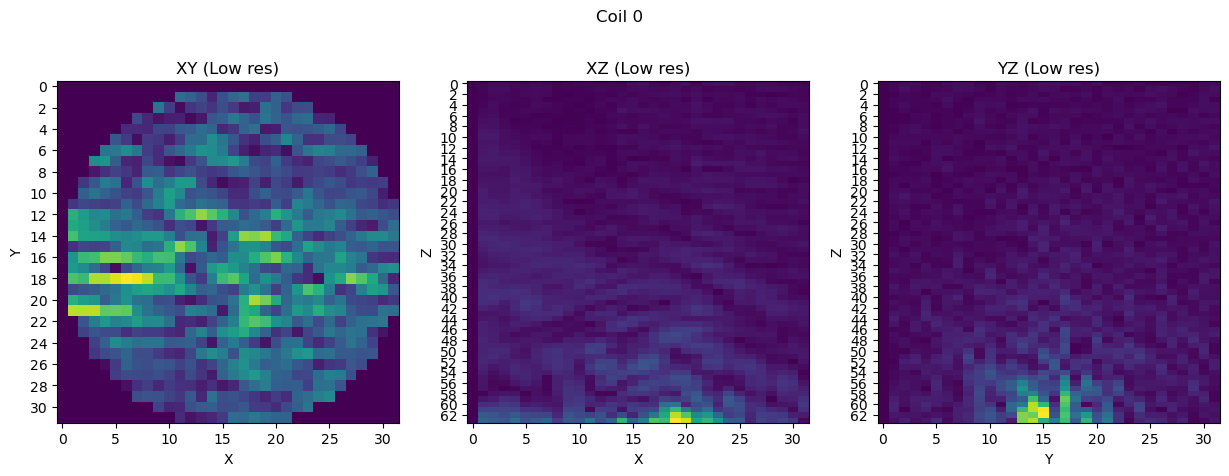

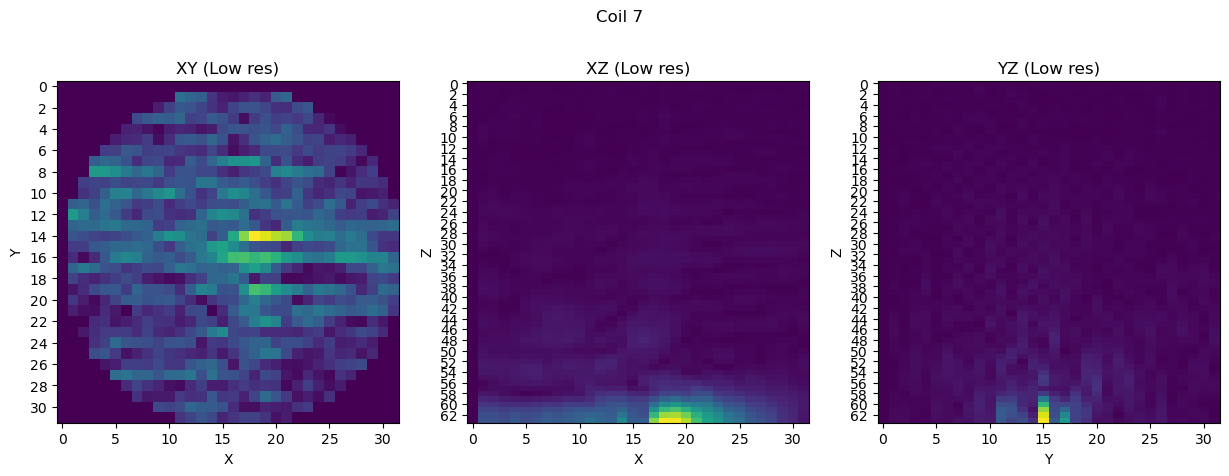

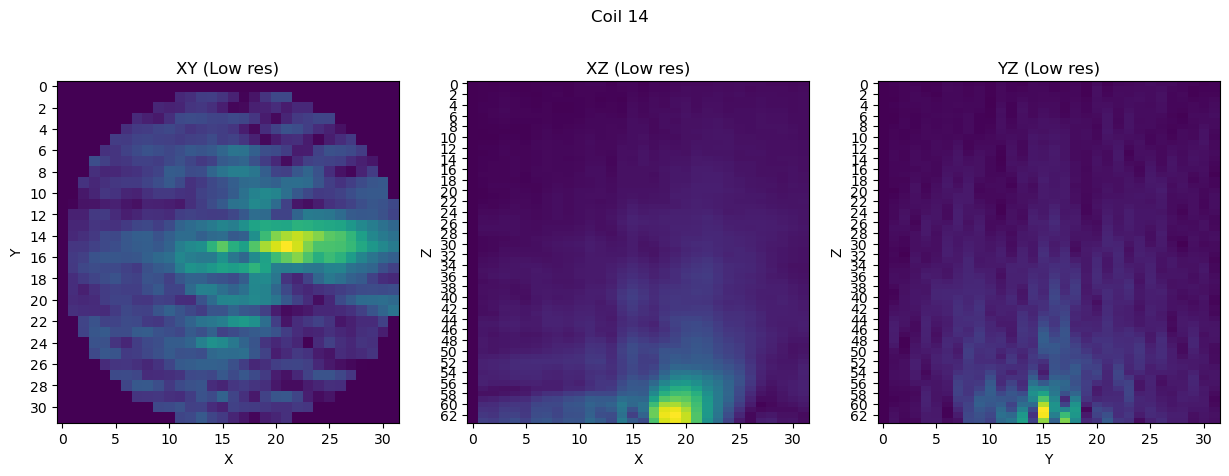

In [4]:
def plot_ksp_data(ksp_data, coil_idx, z_idx=None, y_idx=None, x_idx=None, title_info=""):
    _, Nz, Ny, Nx = ksp_data.shape
    if z_idx is None:
        z_idx = Nz //2
    if y_idx is None:
        y_idx = Ny//2
    if x_idx is None:
        x_idx = Nx //2

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    ## Plot all  3 views
    axs[0].imshow(np.abs(ksp_data[coil_idx,z_idx,:, :]), aspect=1.)
    axs[0].set_yticks(np.arange(0,ksp_data.shape[2],2))
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_title(f"XY {title_info}")

    axs[1].imshow(np.abs(ksp_data[coil_idx,:, y_idx, :]), aspect=ksp_data.shape[2]/ksp_data.shape[1])
    axs[1].set_yticks(np.arange(0,ksp_data.shape[1],2))
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Z")
    axs[1].set_title(f"XZ {title_info}")

    axs[2].imshow(np.abs(ksp_data[coil_idx,:, :, x_idx]), aspect=ksp_data.shape[2]/ksp_data.shape[1])
    axs[2].set_yticks(np.arange(0,ksp_data.shape[1],2))
    axs[2].set_xlabel("Y")
    axs[2].set_ylabel("Z")
    axs[2].set_title(f"YZ {title_info}")
    
    fig.suptitle(f"Coil {coil_idx}")

    plt.show()

plot_ksp_data(ksp_data=coil_ksp_0, coil_idx=0, title_info="(Low res)")
plot_ksp_data(ksp_data=coil_ksp_0, coil_idx=7, title_info="(Low res)")
plot_ksp_data(ksp_data=coil_ksp_0, coil_idx=14,  title_info="(Low res)")

### Display reconstructions for each coil

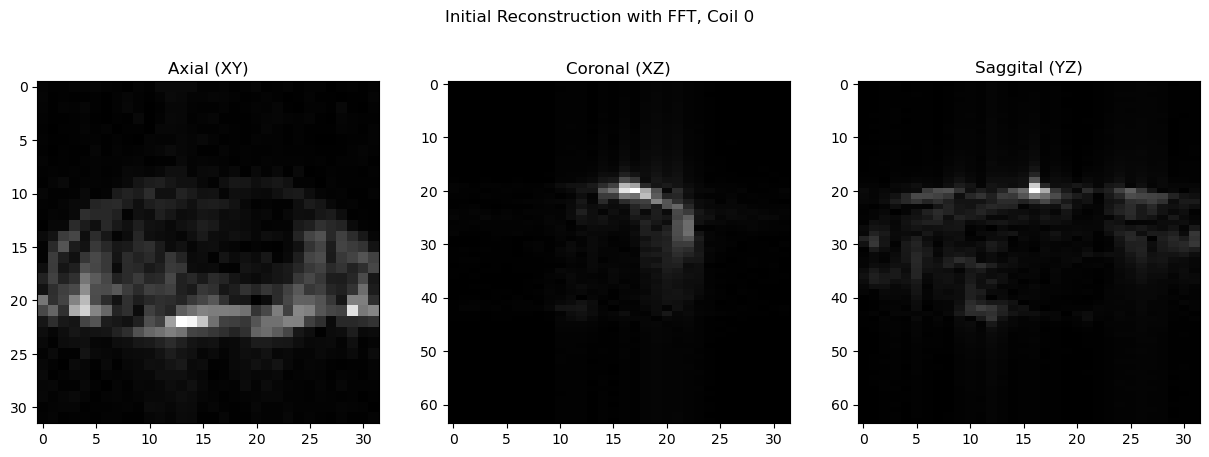

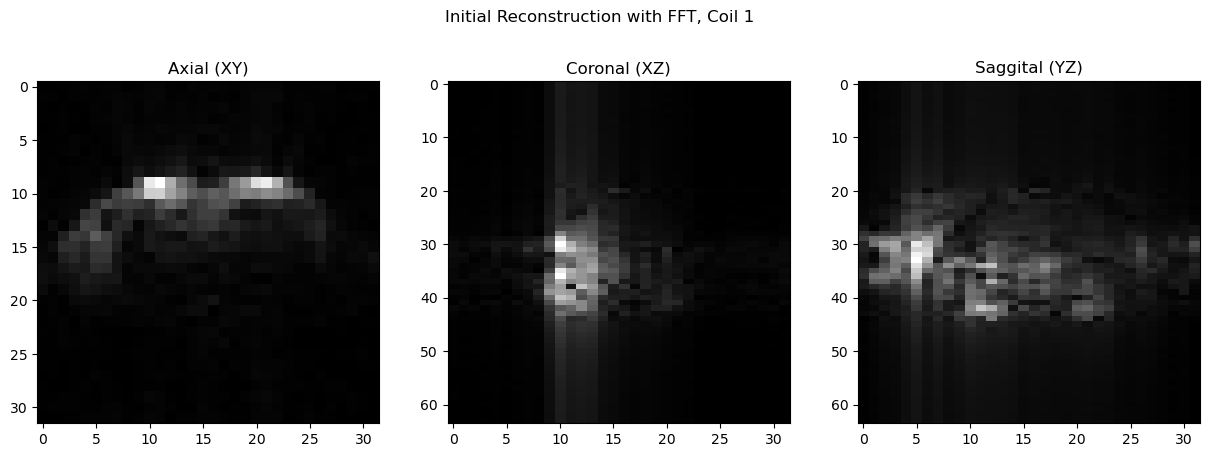

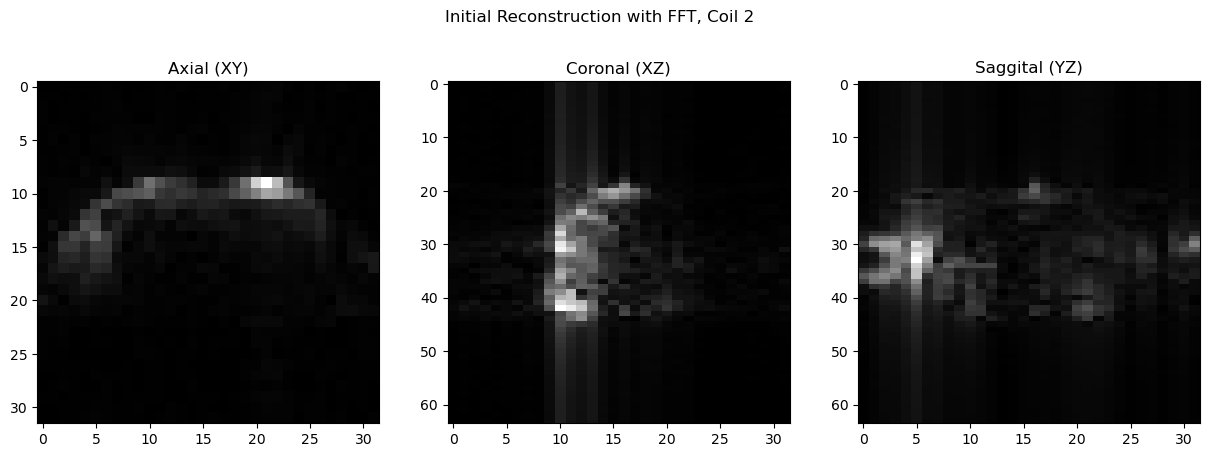

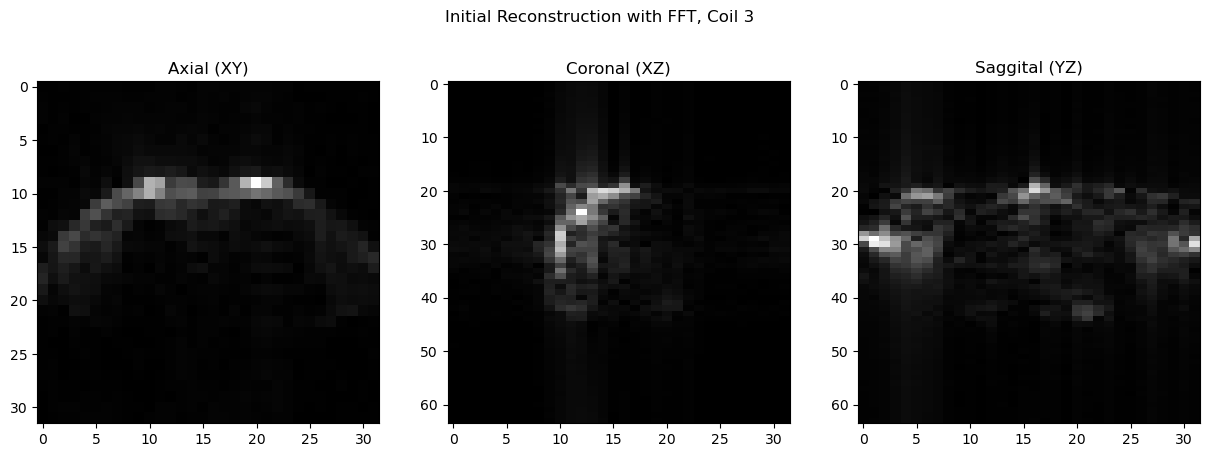

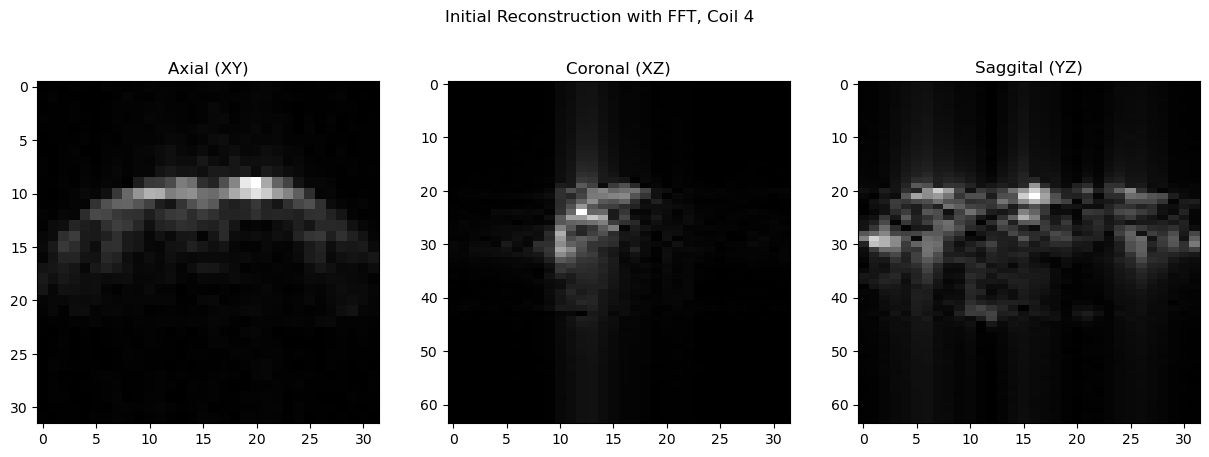

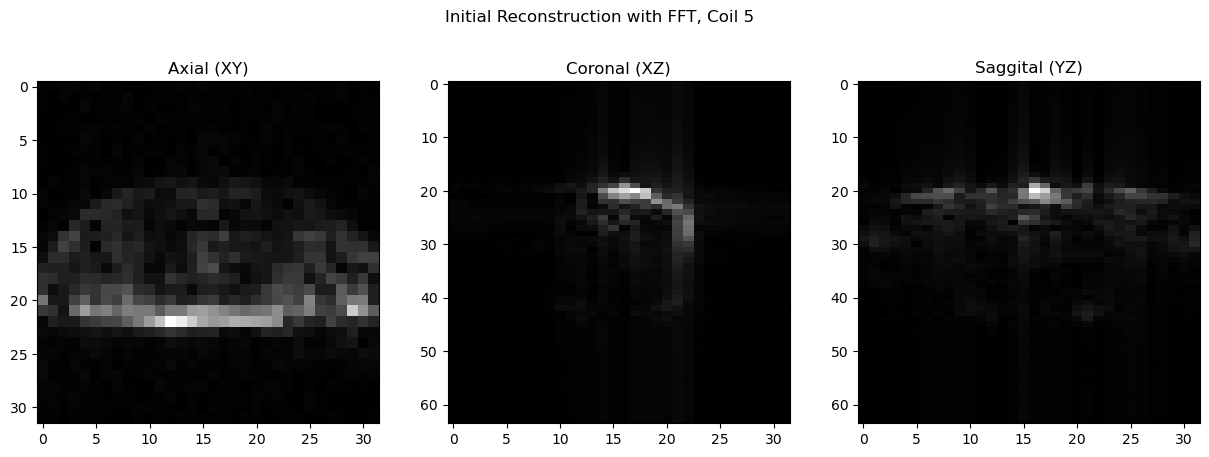

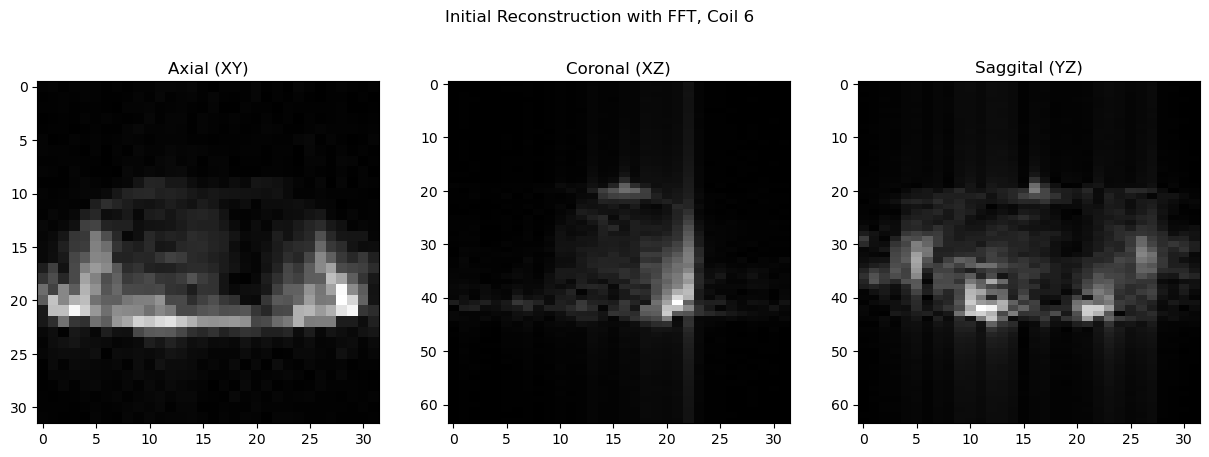

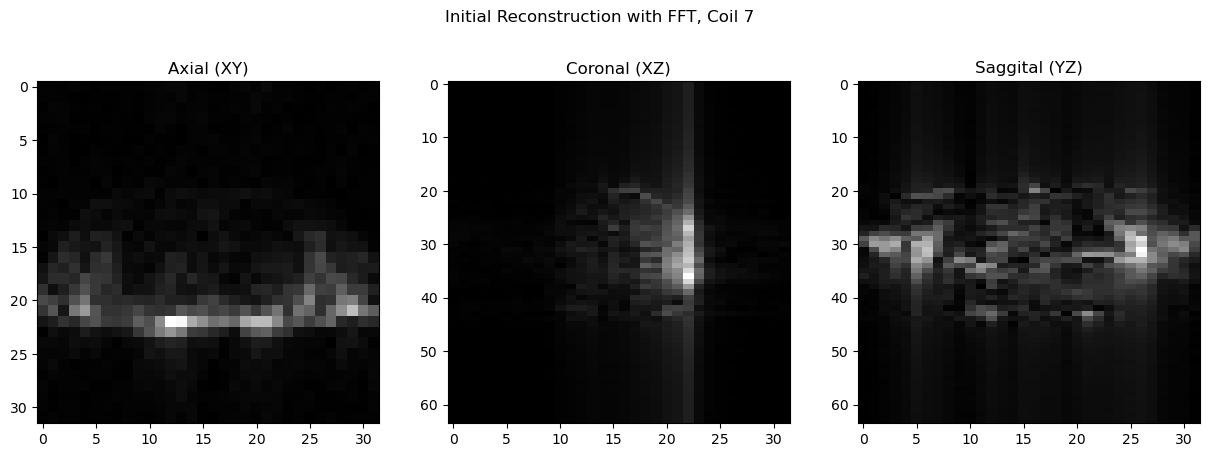

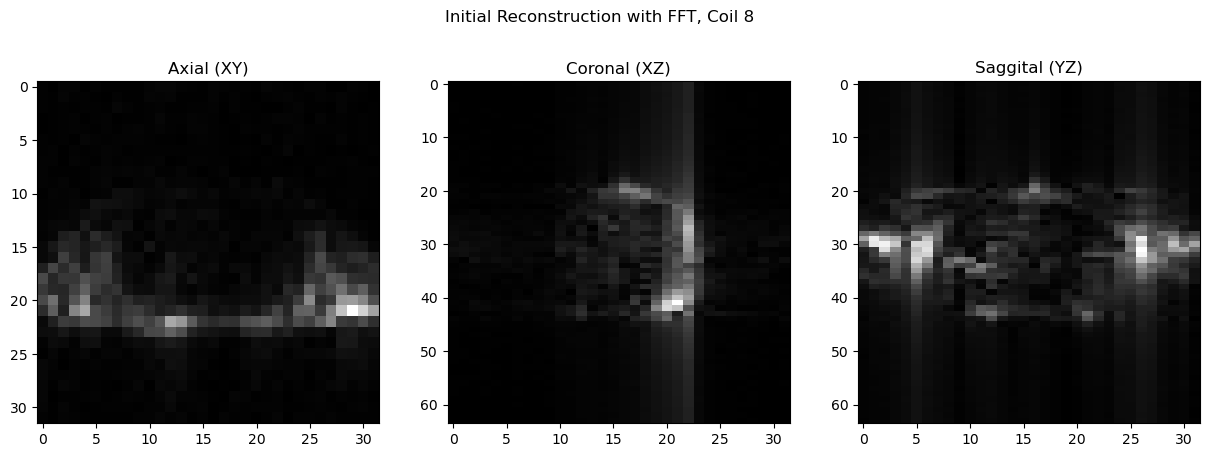

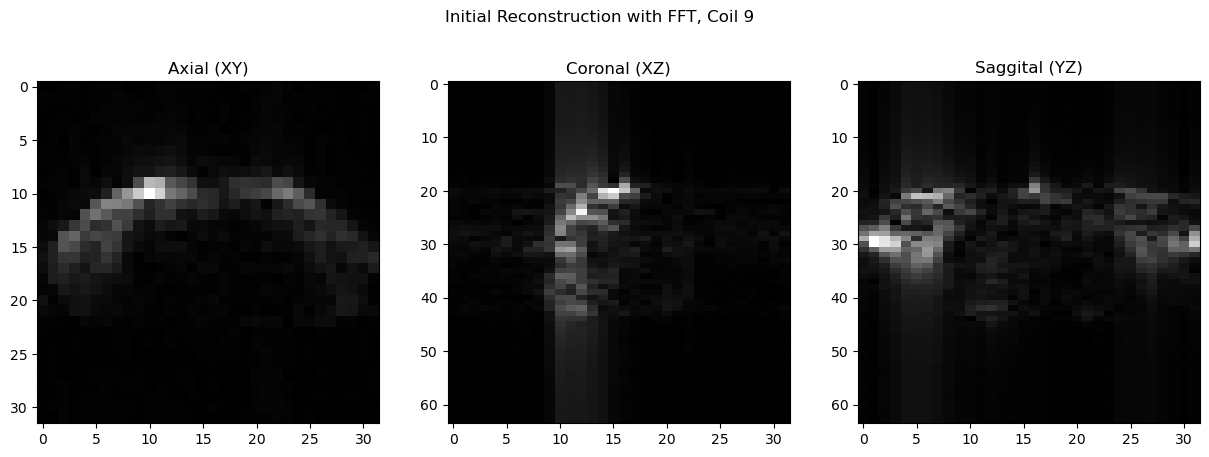

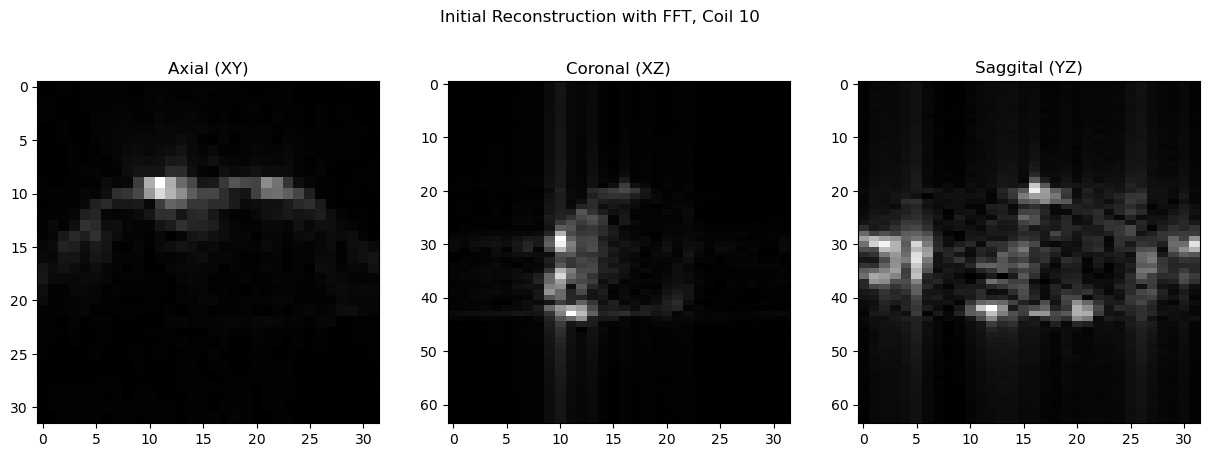

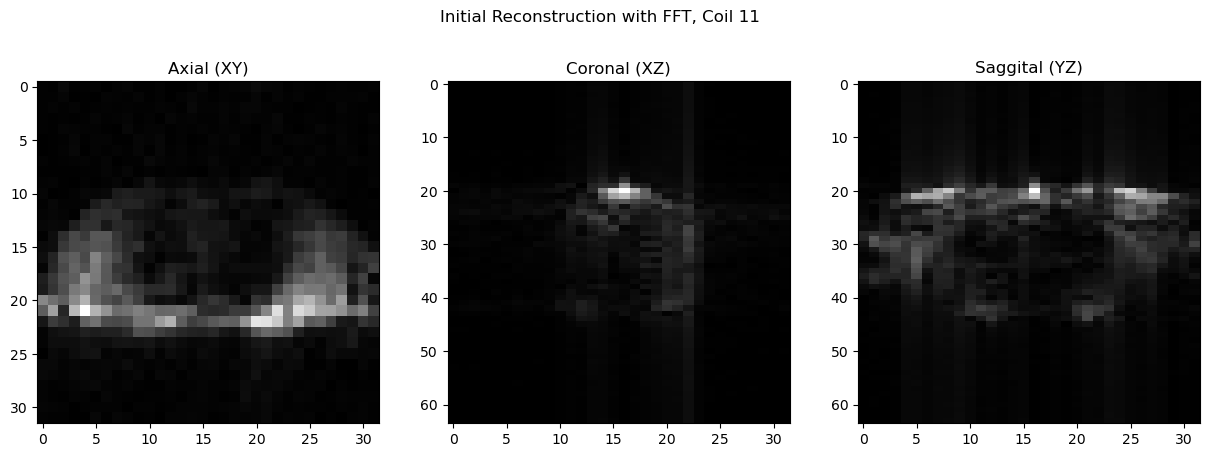

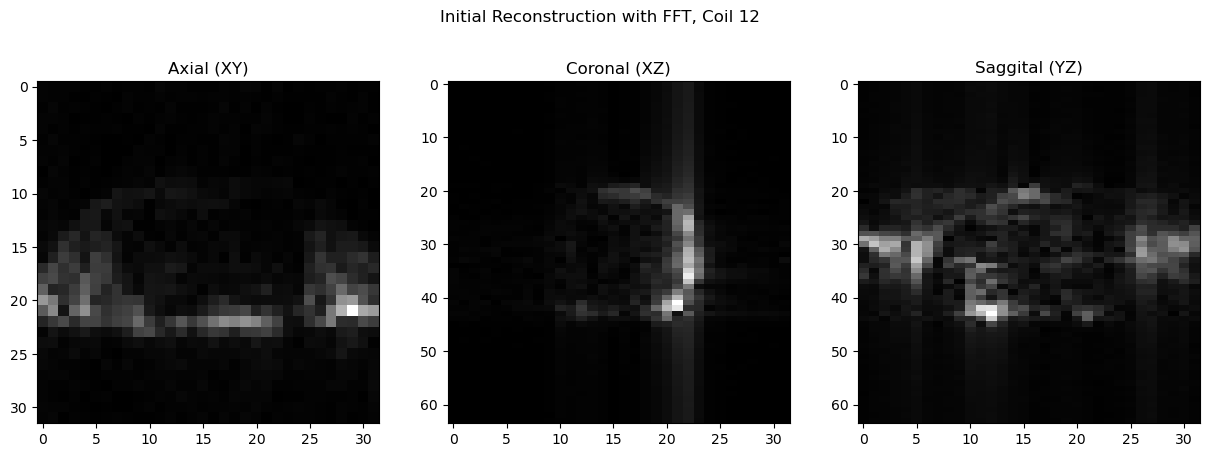

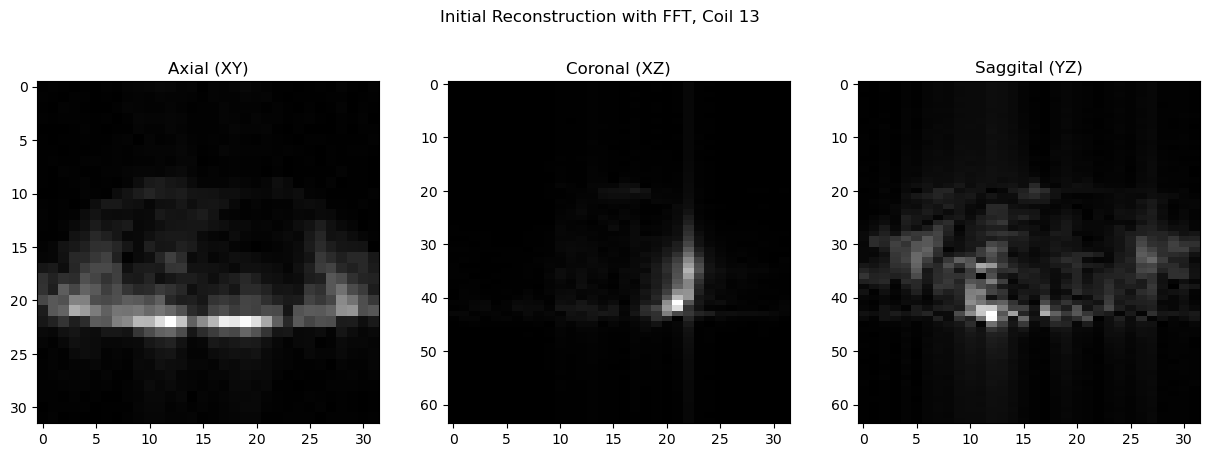

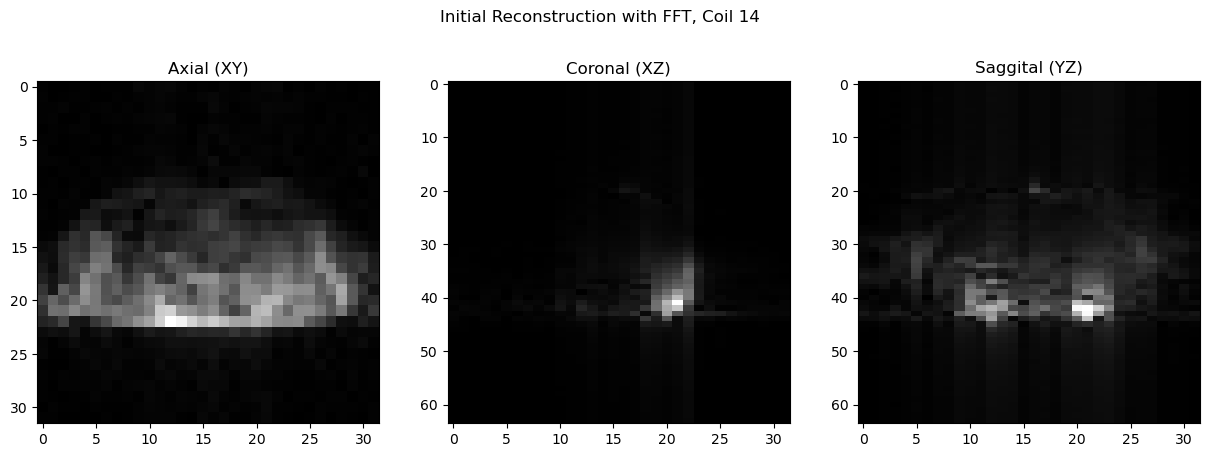

In [7]:
def display_coil_data(coil_ksp, coil_idx, z_idx=None, y_idx=None, x_idx=None):
    Nz, Ny, Nx = coil_ksp[coil_idx].shape
    img =  np.zeros((Nz, Ny, Nx))
    if z_idx is None:
        z_idx = Nz//2
    if y_idx is None:
        y_idx = Ny //2
    if x_idx is None:
        x_idx = Nx//2

    img = np.abs(fft.fftshift(fft.ifftn(fft.ifftshift(coil_ksp[coil_idx]))))
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    aspect = Nx / Nz
    axs[0].imshow(img[z_idx, :, :].T, cmap='gray', aspect=1.)
    axs[0].set_title("Axial (XY)")
    axs[1].imshow(np.rot90(img[:, y_idx, :].T, k=1), cmap='gray', aspect=aspect)
    axs[1].set_title("Coronal (XZ)")
    axs[2].imshow(np.rot90(img[:, :, x_idx].T, k=1), cmap='gray', aspect=aspect)
    axs[2].set_title("Saggital (YZ)")

    fig.suptitle(f"Initial Reconstruction with FFT, Coil {coil_idx}")
    plt.show()

for coil_idx in range(15):
    display_coil_data(coil_ksp_0, coil_idx=coil_idx)

### Root sum-of-squares reconstruction

Coil k-space: (15, 64, 32, 32)
Zero padding from (15, 64, 32, 32) to (128, 64, 64)
Reconstructing 15 coils, shape=(128, 64, 64)


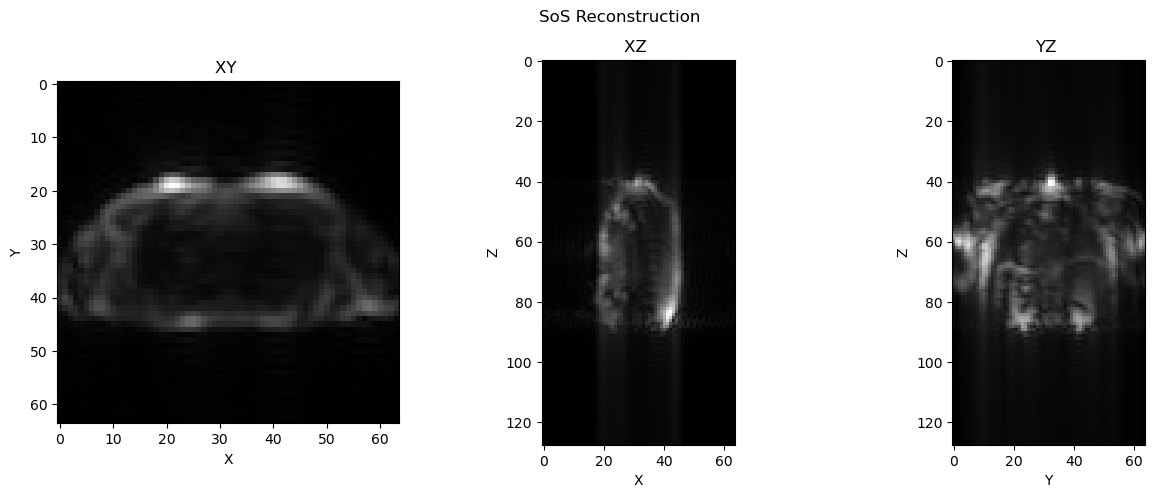

In [10]:
def root_sum_of_squares(coil_ksp, verbose=True):
    ncoils, Nz, Ny, Nx = coil_ksp.shape
    if verbose:
        print(f'Reconstructing {ncoils} coils, shape=({Nz}, {Ny}, {Nx})')

    ## Initialize array for all coil images   
    all_coil_imgs = np.zeros((ncoils, Nz, Ny, Nx), dtype=complex)

    for coil_idx in range(ncoils):
        slice_ksp = coil_ksp[coil_idx]
        all_coil_imgs[coil_idx] = fft.fftshift(fft.ifftn(
                                    fft.ifftshift(slice_ksp, axes=(0,1,2))), axes=(0,1,2))

    all_coil_imgs = np.stack(all_coil_imgs, axis=0)
    return np.sqrt(np.sum(np.abs(all_coil_imgs)**2, axis=0))


def zero_pad_kspace_symmetric(coil_ksp, factor=2):
    """
    Alternative implementation that handles odd/even dimension differences better.
    """
    num_coils, Nz, Ny, Nx = coil_ksp.shape
    Nz_out= Nz * factor if factor  > 1 else Nz
    Ny_out = Ny * factor 
    Nx_out = Nx * factor

    print(f'Zero padding from {coil_ksp.shape} to ({Nz_out}, {Ny_out}, {Nx_out})')

    # Create zero-filled array
    padded = np.zeros((num_coils, Nz_out, Ny_out, Nx_out), dtype=coil_ksp.dtype)
    
    # Calculate padding amounts for each dimension
    pad_z = (Nz_out - Nz)
    pad_y = (Ny_out - Ny) 
    pad_x = (Nx_out - Nx)
    
    # Calculate start and end indices for centering
    z_start = pad_z // 2
    y_start = pad_y // 2
    x_start = pad_x // 2
    
    # Place original data in center
    padded[:, z_start:z_start+Nz, y_start:y_start+Ny, x_start:x_start+Nx] = coil_ksp
    
    return padded


def plot_sos_recon(sos_coils, z_idx=None, y_idx=None, x_idx=None, title_info=""):
    Nz, Ny, Nx = sos_coils.shape
    if z_idx is None:
        z_idx = Nz //2
    if y_idx is None:
        y_idx = Ny//2
    if x_idx is None:
        x_idx = Nx //2

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    ## Plot all  3 views
    ## Data coordinate system is rotated 90 degrees from standard anatomical conventions

    axs[0].imshow((sos_coils[z_idx,:, :]).T, cmap='gray', aspect=1.)
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_title(f"XY {title_info}")

    axs[1].imshow(np.rot90(sos_coils[:, y_idx, :].T, k=1), cmap='gray', aspect=1.)
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Z")
    axs[1].set_title(f"XZ {title_info}")

    axs[2].imshow(np.rot90(sos_coils[:, :, x_idx].T, k=1), cmap='gray', aspect=1.)
    axs[2].set_xlabel("Y")
    axs[2].set_ylabel("Z")
    axs[2].set_title(f"YZ {title_info}")
    
    fig.suptitle(f"SoS Reconstruction")

    plt.show()

print("Coil k-space:", coil_ksp_0.shape)  # Should be (coils, ?, ?, ?)
coil_ksp_0_padded = zero_pad_kspace_symmetric(coil_ksp_0, factor=2)
sos_coils_padded = root_sum_of_squares(coil_ksp_0_padded)
plot_sos_recon(sos_coils_padded)

### Save to NiFTI

In [15]:
### Get FOV from TWIX params

dReadoutFOV = coil_mapped[0]['hdr']['MeasYaps']['sSliceArray']['asSlice'][0]['dReadoutFOV']
dPhaseFOV = coil_mapped[0]['hdr']['MeasYaps']['sSliceArray']['asSlice'][0]['dPhaseFOV']
dThickness = coil_mapped[0]['hdr']['MeasYaps']['sSliceArray']['asSlice'][0]['dThickness']

Z, Y, X = sos_coils_padded.shape

voxel_size_x = dReadoutFOV / X
voxel_size_y = dPhaseFOV/ Y
voxel_size_z = dThickness / Z

voxel_size = [-voxel_size_x, voxel_size_y, voxel_size_z]
print(f'voxel_size = {voxel_size} mm')


### Use voxel spacing to save NiFTI
affine = np.diag(voxel_size + [1])

### Correct array before saving
sos_coils_corrected = np.rot90(sos_coils_padded, k=1, axes=(2,1))
sos_coils_corrected = np.transpose(sos_coils_corrected, (2,1,0))
print(f'After rotation and transpose: {sos_coils_corrected.shape}')

### Save as X,Y,Z
coil_sens_nifti = nib.Nifti1Image(sos_coils_corrected, affine)
nib.save(coil_sens_nifti, 'coil_sens_test_final.nii.gz')
print("NIfTI successfuly saved.")

voxel_size = [-7.8125, 7.8125, 3.905] mm
After rotation and transpose: (64, 64, 128)
NIfTI successfuly saved.
